In [44]:
import sys
sys.path.append('..')
import tqdm, torch, json, pickle, os, gc, time
import pandas as pd
import numpy as np
from collections import OrderedDict
from model.models import GraphEncoder, MoleculeEncoder, ConcatEncoder
from utils.dataset import MoleculeDataset, collate_fn, fpolyv2_collate_fn, fpolyv1_collate_fn
from utils.data import train_test_split, stratified_train_test_split
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
ds1 = MoleculeDataset()
ds2 = MoleculeDataset()
ds1.generate_fpolyv1('../dataset/fpolymers_221123.csv', col_target='TG')
ds2.generate_fpolyv2('../dataset/fpolymers_221123.csv', col_target='TG')
train_data1_, test_data1 = train_test_split(ds1.data, train_ratio=0.9, seed=100)
train_data2_, test_data2 = train_test_split(ds2.data, train_ratio=0.9, seed=100)
train_data3_, test_data3 = stratified_train_test_split(ds2.data, stratum=[d['count'] for d in ds2.data], train_stratum=[1,2,3,4])

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : targets
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : targets
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data


In [48]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_n2i-02'
tag = 'graph/dual_max_tf'
device = 'cpu'
results = {}
for n in tqdm.tqdm(range(100)):
    model_path = os.path.join(root, tag, f'c_{n:04d}')
    if 'dual' in tag:
        train_data, valid_data = train_test_split(train_data2_, train_ratio=0.9, seed=100+n)
        inputs = {
            'train': fpolyv2_collate_fn(train_data, device=device),
            'valid': fpolyv2_collate_fn(valid_data, device=device),
            'test': fpolyv2_collate_fn(test_data2, device=device),
        }
    else:
        train_data, valid_data = train_test_split(train_data1_, train_ratio=0.9, seed=100+n)
        inputs = {
            'train': fpolyv1_collate_fn(train_data, device=device),
            'valid': fpolyv1_collate_fn(valid_data, device=device),
            'test': fpolyv1_collate_fn(test_data1, device=device),
        }
    if 'sing' in model_path:
        n_head = 1
    elif 'dual' in model_path:
        n_head = 2
    else:
        n_head = 5
    t1 = time.time()
    sd = torch.load(os.path.join(model_path, '00200.model.torch'), map_location=device)
    with open(os.path.join(model_path, 'param.json')) as f:
        p = json.load(f)

    if 'graph' in p['encoder_type']:
        encoders = [GraphEncoder(**p['encoder_params']) for _ in range(n_head)]
    elif 'mol' in p['encoder_type']:
        encoders = [MoleculeEncoder(**p['encoder_params']) for _ in range(n_head)]
    elif 'cat' in p['encoder_type']:
        encoders = [ConcatEncoder(**p['encoder_params']) for _ in range(n_head)]

    for i in range(n_head):
        x = 'ABCDE'[i]
        h = f'encoder.'
        if 'sing' not in tag:
            h = f'encoder_{x}.'
        encoders[i].load_state_dict(OrderedDict({k.replace(h,''):v for k,v in sd.items() if h in k}))
        encoders[i].to(device)
        encoders[i].eval()
    vectors = {}
    with torch.no_grad():
        for k, (feat, target, _) in inputs.items():
            if 'dual' in model_path:
                hs = []
                fs = []
                for i, x in enumerate('fc'):
                    f = feat[f'feat_{x}']['mol_feat']
                    h = encoders[i](**feat[f'feat_{x}'])
                    w = feat[f'feat_{x}']['weight']
                    b = feat[f'batch_{x}']
                    h = torch.hstack([h, h*w])
                    if 'add' in tag:
                        hs.append(global_add_pool(h, b))
                        fs.append(global_add_pool(f, b))
                    elif 'max' in tag:
                        hs.append(global_max_pool(h, b))
                        fs.append(global_max_pool(f, b))
                ms = [h.shape[0] for h in hs]
                mx = np.max(ms)
                p = torch.zeros_like(torch.vstack(hs))
                h = torch.hstack([torch.vstack([h, p[:mx-m]]) for h, m in zip(hs, ms)])
                p = torch.zeros_like(torch.vstack(fs))
                f = torch.hstack([torch.vstack([f, p[:mx-m]]) for f, m in zip(fs, ms)])
            else:
                w = torch.concat([feat[f'mol_{x}']['weight'] for x in 'ABCDE'], dim=-1).to(device)
                N, M = w.shape
                if 'sing' in model_path:
                    hs = [encoders[0](**feat[f'mol_{x}']) for x in 'ABCDE']
                    fs = [feat[f'mol_{x}']['mol_feat'] for x in 'ABCDE']
                elif 'mult' in model_path:
                    hs = [encoders[i](**feat[f'mol_{x}']) for i,x in enumerate('ABCDE')]
                    fs = [feat[f'mol_{x}']['mol_feat'] for i,x in enumerate('ABCDE')]
                h = torch.concat(hs, dim=-1).view(N*M, -1)
                f = torch.concat(fs, dim=-1).view(N*M, -1)
                h = h * (w != 0).long().view(-1,1)
                f = f * (w != 0).long().view(-1,1)
                h = torch.concat([w.view(-1,1) * h, h], dim=-1)
                f = torch.concat([w.view(-1,1) * h, h], dim=-1)
                b = (torch.arange(N*M)/5).long().to(device)
                if 'add' in tag:
                    h = global_add_pool(h, b)
                    f = global_add_pool(f, b)
                elif 'max' in tag:
                    h = global_max_pool(h, b)
                    f = global_max_pool(f, b)
            vectors[k] = (h.cpu().numpy(), f.cpu().numpy(), target.cpu().numpy())
    results[n] = {}
    for ds in ['train','valid','test']:
        with open(os.path.join(model_path, f'00200.{ds}.pkl'),'rb') as f:
            _, t, p = pickle.load(f)
        results[n][ds] = [[t,p]]
        
    for i in range(2):
        train_data = xgb.DMatrix(vectors['train'][i], vectors['train'][2])
        valid_data = xgb.DMatrix(vectors['valid'][i], vectors['valid'][2])
        test_data = xgb.DMatrix(vectors['test'][i], vectors['test'][2])
        params = {'objective':'reg:squarederror', 'max_depth':8}
        model = xgb.train(params=params, dtrain=train_data, num_boost_round=30)
        p_train = model.predict(train_data)
        p_valid = model.predict(valid_data)
        p_test  = model.predict(test_data)
        results[n]['train'].append([vectors['train'][2], p_train])
        results[n]['valid'].append([vectors['valid'][2], p_valid])
        results[n]['test'].append([vectors['test'][2], p_test])
        
infos = {'train':[], 'valid':[],'test':[]}
for vals1 in results.values():
    for ds, vals2 in vals1.items():
        infos[ds].append([r2_score(t, p) for t, p in vals2])
for ds, vals in infos.items():
    printing = f'{ds}\t'
    for a, s in zip(np.mean(vals, axis=0), np.std(vals, axis=0)):
        printing += f'| {a:6.3f} {s:5.3f}'
    print(printing)

100%|██████████| 100/100 [00:12<00:00,  8.20it/s]

train	|  0.907 0.021|  0.998 0.001|  0.902 0.007
valid	|  0.561 0.190|  0.538 0.206|  0.441 0.204
test	|  0.611 0.066|  0.593 0.076|  0.542 0.045


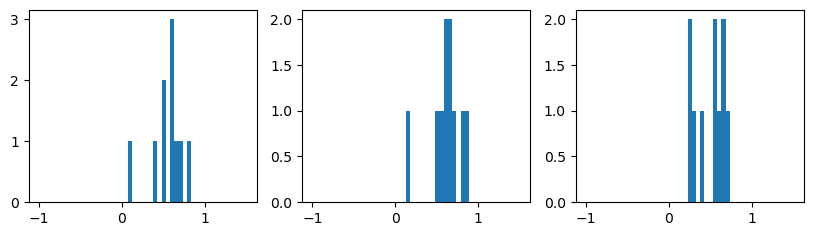

In [64]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1,3,figsize=(10, 2.5))
for vals, ax in zip(np.array(infos['valid']).T, axs):
    ax.hist(vals[:10], bins=np.linspace(-1, 1.5, 50))

0.09257259614350759
0.09264016311509114
0.09066455501723661


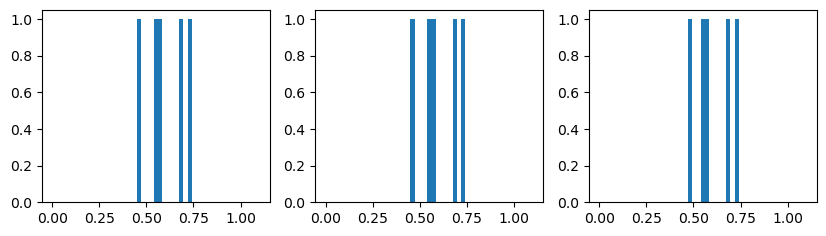

In [74]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_2/graph/tf/'
outs = {'train':[],'valid':[],'test':[]}
for i in range(5):
    for ds in ['train','valid','test']:
        with open(os.path.join(root, f'cv_000{i}/00500.{ds}.pkl'),'rb') as f:
            _, t, p = pickle.load(f)
        outs[ds].append(r2_score(t,p))
f, axs = plt.subplots(1,3,figsize=(10, 2.5))
for vals, ax in zip(outs.values(), axs):
    ax.hist(vals[:10], bins=np.linspace(0.0, 1.1, 50))
    print(np.std(vals))

In [96]:
train_data = xgb.DMatrix(*inputs['train'][0]['mol_feat'])
valid_data = xgb.DMatrix(*inputs['valid'][0]['mol_feat'])
test_data = xgb.DMatrix(*inputs['test'][0]['mol_feat'])
params = {'objective':'reg:squarederror', 'max_depth':10}
model = xgb.train(params=params, dtrain=train_data, num_boost_round=20)
p_train = model.predict(train_data)
p_valid = model.predict(valid_data)
p_test  = model.predict(test_data)
for p, (_, t) in zip([p_train, p_valid, p_test], vectors.values()):
    print(r2_score(t, p))

KeyError: 'mol_feat'

In [9]:
def to_vector(data, c = 1):
    feat, target, ids = fpolyv1_collate_fn(data, 'cpu')
    
    ws = [m['weight'] for m in feat.values()]
    if c == 1:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 2:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).max(dim=0).values.numpy()
    elif c == 3:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 4:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).max(dim=0).values.numpy()
    return ff, target.numpy(), ids


In [142]:
from utils.data import CrossValidation
from bayes_opt import BayesianOptimization
import pickle

def obj_fnc(eta):
    global max_depth, train_data, valid_data, m_best, best
    params = {
                'max_depth':max_depth,
                'min_child_weight': 1,
                'eta':eta,
                # Other parameters
                'objective':'reg:squarederror',
                'eval_metric':'mae'
            }
    bst = xgb.train(params, dtrain=train_data, num_boost_round=50, evals=[(valid_data, 'valid')], early_stopping_rounds=5, verbose_eval=False)

    tt = train_data.get_label()
    vt = valid_data.get_label()
    tp = bst.predict(train_data, iteration_range=(0, bst.best_iteration+1))
    vp = bst.predict(valid_data, iteration_range=(0, bst.best_iteration+1))
    train_r2, train_rmse = r2_score(tt, tp), np.sqrt(mean_squared_error(tt, tp))
    valid_r2, valid_rmse = r2_score(vt, vp), np.sqrt(mean_squared_error(vt, vp))
    m = np.abs(10000 * train_r2 * valid_r2 * valid_r2 / (train_rmse * valid_rmse * valid_rmse))
    if train_r2 < 0 or valid_r2 < 0:
        m = -m
    if m > m_best:
        m_best = m
        best = {'params':params, 'r2':[train_r2, valid_r2], 'rmse':[train_rmse, valid_rmse], 'raw':[tt, tp, vt, vp]}
    return m

    
cv = CrossValidation(n_fold=3, data=ds1.data)
for i, feat in enumerate(['mol_avg','atom_avg']):
    print(feat, '-'*50)
    bests = {feat:[]}
    vals = []
    for j in range(3):
        train_data, valid_data = cv[j]
        train_x, train_y, _ = to_vector(train_data, i*2 + 1)
        valid_x, valid_y, _ = to_vector(valid_data, i*2 + 1)

        train_data = xgb.DMatrix(train_x, train_y)
        valid_data = xgb.DMatrix(valid_y, valid_y)
        best = {'params':[0,0], 'r2':[0,0], 'rmse':[0,0]}
        m_best = -1e-5
        for max_depth in range(1, 20):
            bo = BayesianOptimization(obj_fnc, pbounds={'eta':[1e-2, 1]}, random_state=100, verbose=0)
            bo.maximize(init_points=10, n_iter=90)
        bests[feat].append(best)
        tr2, vr2 = best['r2']
        trm, vrm = best['rmse']
        vals.append([tr2, vr2, trm, vrm])
        print(f'Fold: {i} : {tr2:7.3f} | {vr2:7.3f} / {trm:7.2f} | {vrm:7.2f}')
    print('-'*50)
    vs = np.stack([np.mean(vals, axis=0), np.std(vals, axis=0)]).T.reshape(-1)
    print('Average : {:7.3f} {:5.3f} | {:7.3f} {:5.3f} / {:7.2f} {:4.2f} | {:7.2f} {:4.2f}\n'.format(*vs))
    with open(f'./xgb_{feat}.pkl','wb') as f:
        pickle.dump(bests, f)
    


mol_avg --------------------------------------------------
Fold: 0 :   0.999 |   0.129 /    0.88 |   31.59
Fold: 0 :   0.999 |   0.022 /    1.12 |   28.55
Fold: 0 :   0.992 |   0.111 /    2.87 |   26.38
--------------------------------------------------
Average :   0.997 0.003 |   0.087 0.046 /    1.62 0.89 |   28.84 2.14

atom_avg --------------------------------------------------
Fold: 1 :   0.000 |   0.000 /    0.00 |    0.00
Fold: 1 :   0.985 |   0.056 /    3.82 |   28.06
Fold: 1 :   0.982 |   0.201 /    4.29 |   25.00
--------------------------------------------------
Average :   0.655 0.464 |   0.086 0.085 /    2.70 1.92 |   17.69 12.57



In [140]:
best

{'params': {'max_depth': 5,
  'min_child_weight': 1,
  'eta': 0.9899178523172626,
  'objective': 'reg:squarederror',
  'eval_metric': 'mae'},
 'r2': [0.9927515355013128, 0.017204007501630758],
 'rmse': [2.7201722, 26.485558],
 'raw': [array([ 6.9150e+01,  3.6500e+01,  8.4360e+01,  4.9890e+01,  3.4730e+01,
          9.3180e+01,  4.7900e+01,  1.0751e+02,  1.3584e+02,  5.2400e+01,
          4.8800e+01,  6.0700e+01,  4.5620e+01,  5.2000e+01,  1.1450e+02,
          1.0220e+02,  4.1170e+01,  5.8760e+01,  2.7100e+01,  1.0370e+02,
          8.6640e+01,  1.0052e+02,  1.4267e+02,  2.9400e+01,  8.3450e+01,
          6.5060e+01,  7.8870e+01,  7.7660e+01,  7.7690e+01, -2.9230e+01,
          1.0329e+02,  3.7100e+01,  6.1470e+01,  1.0000e-01,  8.4400e+01,
          4.8770e+01,  4.9300e+01,  6.0310e+01,  5.4350e+01,  7.8510e+01,
          9.5410e+01,  8.3800e+01,  5.1500e+01, -1.4560e+01,  6.0080e+01,
          7.1970e+01,  1.3362e+02,  8.6660e+01,  5.1150e+01,  9.0400e+01,
          3.6450e+01,  8.80

In [121]:
bst = xgb.train(
    params={'max_depth':3, 'eta':0.3, 'eval_metric':'rmse'},
    dtrain=train_data, num_boost_round=50, evals=[(valid_data, 'valid')],
    early_stopping_rounds=5)

[0]	valid-rmse:47.83573
[1]	valid-rmse:50.29416
[2]	valid-rmse:46.12107
[3]	valid-rmse:40.24706
[4]	valid-rmse:36.01260
[5]	valid-rmse:34.98004
[6]	valid-rmse:34.36175
[7]	valid-rmse:35.06878
[8]	valid-rmse:35.52806
[9]	valid-rmse:34.34357
[10]	valid-rmse:34.23130
[11]	valid-rmse:33.47430
[12]	valid-rmse:33.60856
[13]	valid-rmse:35.56438
[14]	valid-rmse:35.52018
[15]	valid-rmse:36.50436
[16]	valid-rmse:36.59705


In [128]:
score = []
t = valid_data.get_label()
for i in range(0,bst.best_iteration+5):
    p = bst.predict(valid_data, iteration_range=(0, i+1))
    r2 = r2_score(t, p)
    rmse = np.sqrt(mean_squared_error(t, p))
    score.append([i, r2, rmse])

In [134]:
p = bst.predict(valid_data, iteration_range=(0, bst.best_iteration+1))
r2 = r2_score(t, p)
rmse = np.sqrt(mean_squared_error(t, p))
r2, rmse

(-0.2745526305956041, 33.474304)

In [17]:

def to_vector(feat):
    fs = []
    for i, x in enumerate('fc'):
        f = feat[f'feat_{x}']['mol_feat']
        w = feat[f'feat_{x}']['weight']
        b = feat[f'batch_{x}']
        fs.append(global_add_pool(f * w, b))
    ms = [f.shape[0] for f in fs]
    mx = np.max(ms)
    p = torch.zeros_like(torch.vstack(fs))
    f = torch.hstack([torch.vstack([f, p[:mx-m]]) for f, m in zip(fs, ms)])
    return f.cpu().numpy()

train_feat, train_target, _ = fpolyv2_collate_fn(train_data3_)
test_feat, test_target, _ = fpolyv2_collate_fn(test_data3)

train_x = to_vector(train_feat)
test_x = to_vector(test_feat)

train_data = xgb.DMatrix(train_x, train_target.cpu().numpy())
test_data = xgb.DMatrix(test_x, test_target.cpu().numpy())
params = {'objective':'reg:squarederror', 'max_depth':5}
model = xgb.cv(params=params, dtrain=train_data, num_boost_round=10)
#p_train = model.predict(train_data)
#p_valid = model.predict(valid_data)
#p_test  = model.predict(test_data)
model


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,52.153999,0.048631,53.824095,0.809539
1,38.111155,0.130573,42.024383,1.751434
2,28.176435,0.123820,34.806049,2.802056
3,21.093472,0.115588,29.726211,2.939815
4,16.007560,0.170853,26.816880,3.294074
5,12.415956,0.261193,24.983658,3.347403
6,9.920381,0.322861,24.133555,3.471736
7,7.937590,0.113849,23.696519,3.583170
8,6.651537,0.098528,23.345791,3.585359
9,5.628855,0.161175,23.154989,3.613366


In [8]:
fpolyv1_collate_fn(train_data)

({'mol_A': {'atom_feat': tensor([[12.0110,  1.0000,  3.0000,  ...,  0.0000,  0.0000,  3.3164],
           [12.0110,  3.0000,  0.0000,  ...,  0.0000,  0.0000,  3.3164],
           [12.0110,  1.0000,  2.0000,  ...,  0.0000,  0.0000,  3.3164],
           ...,
           [18.9980,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  5.1314],
           [18.9980,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  5.1314],
           [18.9980,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  5.1314]]),
   'bond_feat': tensor([[1., 1., 0., 0., 0.],
           [1., 1., 0., 0., 0.],
           [2., 2., 0., 1., 0.],
           ...,
           [1., 1., 0., 0., 0.],
           [1., 1., 0., 0., 0.],
           [1., 1., 0., 0., 0.]]),
   'bond_idx': tensor([[   0,    1,    1,  ..., 3287, 3282, 3288],
           [   1,    0,    2,  ..., 3282, 3288, 3282]]),
   'mol_feat': tensor([[12.1225, -5.7199, 12.1225,  ...,  1.2230,  2.2510,  0.0000],
           [13.2606, -7.9449, 13.2606,  ...,  0.8450,  1.0110,  1.2360],
           